## Team Members:

### Zafar Ahamad (111195037)
### Ubaid Ullah Hafeez (111195374)


## Part 1
    Our Scoring function, f takes data about a property as input and returns a pair of non_geographical score and geographical score:
f(**data**) = (**non_geographical score**, **geographical score**)

### Non-Geographical Score

#### Some Interesting Facts About Real-Estate :
       Our Scoring function is based on some of the observations about houses being sold in last few years by some real-estate researchers which are as follows :
- Buyers generally prefer centrally air-conditioned homes and are willing to pay more
- Houses sold in last three years have 2-3 average number of bathrooms
- Houses sold in last three years have 3-4 average number of bedrooms
- Most of the Houses sold have a garage which has space for 2 cars
- In California, heat pumps are perferred heating system because of energy efficiency and providing necesssary amount of heating when needed
- Most of the buyers prefer a single story or a double story house, not more than that. In addition to that people prefer to have an attic or basement for extra space and storage
- Other than bedrooms, people prefer to have some extra rooms like laundry room, a dine-in kitchen, some common sitting room etc and are willing to pay more for these
- Most preferred unit count is one
- People prefer to have a patio and storage room and are in most cases willing to pay more for these.

#### Some Deductions:
    Following are some considerations based on our own sniff test after looking at the data:
- A newer house is more desirable to an old one, unless the old house is an antique one and is well maintained and well kept
- Areas where tax is high are those with good neighborhoods and have really good facilities for residents, so the houses with higher tax / sqft of area should be more desirable

#### Scoring Function
    Keeping the above things in mind, we picked a subset of 15 columns from the given data and scored each of them indivivually such that score reflects the above mentioned points. General technique we used is to find the best in the each column and assign decreasing score from there to all the other values based on how far apart these are from the best. After assigning scores, normaliz each of the column individually. Now, to find the accumalated score, we just sum the score of all the columns. Following is the list of columns that we used:

- **airconditioningtypeid**
- **bathroomcnt**
- **bedroomcnt**
- **buildingqualitytypeid**
- **garagetotalsqft**
- **heatingorsystemtypeid **
- **numberofstories**
- **propertylandusetypeid**
- **roomcnt**
- **unitcnt**
- **yardbuildingsqft17**
- **yardbuildingsqft26**
- **yearbuilt**
- **landtaxvaluedollarcnt**

#### How good is the scoring function
    We think our scoring function is decent based on the two observations. First one being the difference in the scores of houses on the extreme values being higher as compared to differences in the scores close to mean being lower. Second observation is that the distribution looks close to normal distribution which suggests that it scores houses in a way that we are used to see, which decent ennough reasoning to say that this scoring function worked just fine.
    
### Geographical Score

#### Finding Correct Zip-Codes
    
   Zillow's zipcode are not the zip code but a mapping to it. They mapped each zip code to a table id. We used a data-set (https://gist.github.com/erichurst/7882666) that gives us the latitude and longitude of all Zipcodes of United States. From that datasets we filtered out the zip codes of our desired counties. Now we did clustering based on the Zillow zip-ids. We measures the distance of each points from the zipcode geo-graphical coordinates and assigend the correct zip code ids based on majority voting technique. We also ran randomized experiments to see if our predicted zip code is correct.
    Now we have correct Zip code of each house. We found a dataset __Forbes 500 Most Expensive Zip Codes__ (https://www.forbes.com/sites/samanthasharf/2016/12/08/full-list-americas-most-expensive-zip-codes-2016/), conducted by **Altos Research**. They considered the following factors:
- **Median Price**
- **Average Days on Market**
- **Inventory**
- **Previous year rank**
- **Different facilities in that Zip code etc**

    We found 192 most expensive zip in california. Among these 192 zipcode 64 of them was our desired zipcodes for the three counties. We did imputation based on the geographic distance to measure the relative expensiveness score for the rest of the zip codes in our dataset.
    
    Now we created a data-set that compared the price of the houses similar to the best house given by the above non geographical score across all the zipcodes and based on this, we assigned score to to each of the zipcodes such that the zipcode where a similar house is cheaper is given a lower score as compared to the expensive one.


In [29]:
%matplotlib inline

In [31]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from statistics import mean
import xgboost as xgb
from copy import deepcopy
from sklearn.utils import shuffle
from pylab import rcParams
import operator
from math import *

'''
A Function to get Stats about a columns, 
@params, df = dataframe, col = column_name
'''
def get_details(df, col):
	print(col)
	tmp = df.loc[:, col]
	uni = tmp.unique()
	uni.sort()
	print('Unique Entries : ', uni)
	# print(type(tmp.unique()))
	print('Total Number of Unique Entries', len(tmp.unique()))
	print('Total Number of NaNs/Missing Values: ', tmp.isnull().sum())
	# print(int(tmp.mean()))
	print('Mean : ', tmp.mean())
	print('Max : ', tmp.max())
	print('Min : ', tmp.min())


# Array to hold all the columns that are part of desirability scoring function
desirable_features = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'garagetotalsqft', 'heatingorsystemtypeid', 
'numberofstories', 'propertylandusetypeid', 'roomcnt', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'landtaxvaluedollarcnt']

# Default Dataset to avoid loading again and again




#### Non-Geaographical Score

/Users/zafar-PC/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


*********** least Desirable House (ParcelID) ***********
13987714
12560578
14078586
14449860
14063161
13983031
14064808
14026495
14064814
13918731

*********** most Desirable House (ParcelID) ***********
14605326
14605300
14673128
14646932
14634838
14383714
14625285
14315174
14060259
14060560


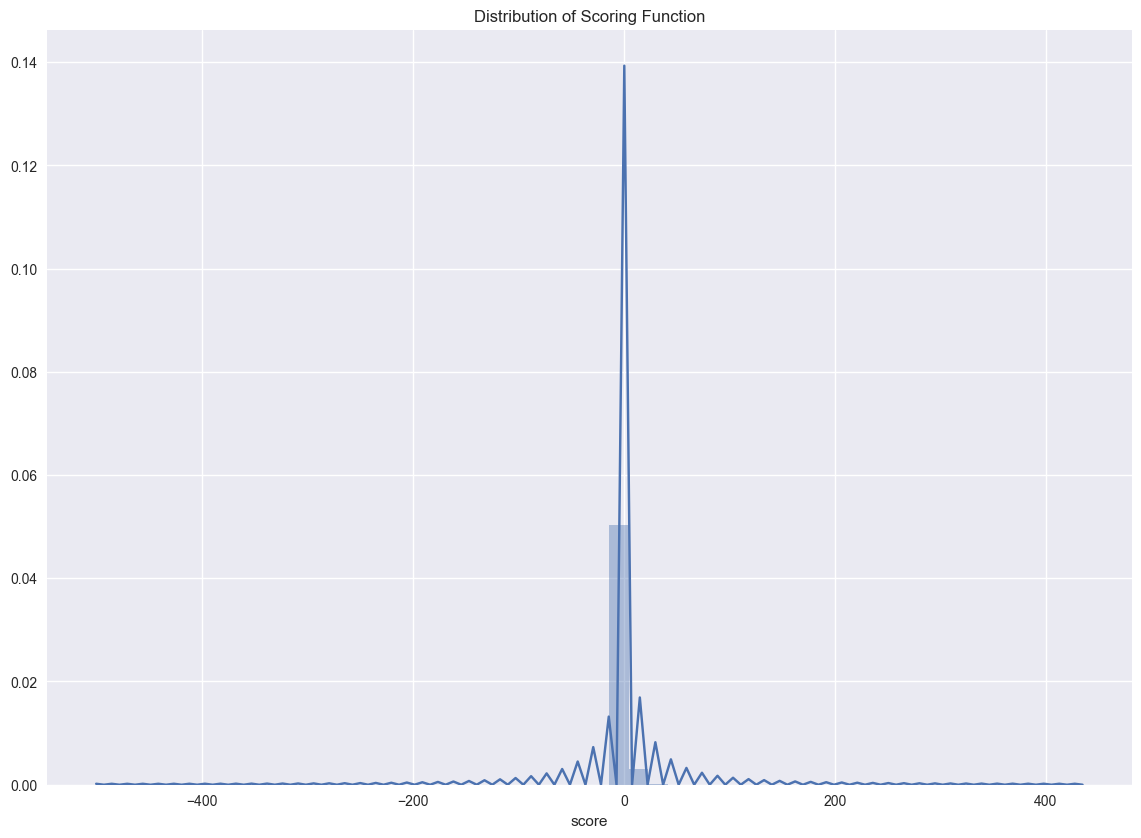

In [33]:
# Reading Data
properties_file = 'properties_2017.csv'
df = pd.read_csv(properties_file)
# print(df.shape)


# Filling the Dataframe with scores instead of the values for all the features that are part of desirability function
tmp = df.loc[:,'airconditioningtypeid']
tmp.fillna(6, inplace=True)
df['airconditioningtypeid'].replace([1, 4], 1, inplace=True)
df['airconditioningtypeid'].replace([2, 3, 6, 7, 8, 9, 10, 11, 12, 13], 0, inplace=True)
df['airconditioningtypeid'].replace([5], -1, inplace=True)


tmp = df.loc[:,'bathroomcnt']
tmp.fillna(tmp.mean(), inplace=True)
tmp = df.loc[:,'bathroomcnt'] - 2.5
df.loc[:,'bathroomcnt'] = tmp
# df.loc[(df['bathroomcnt'] > 2.5), 'bathroomcnt'] = -2.5
# df.loc[(df['bathroomcnt'] >= 0), 'bathroomcnt'] = 1


tmp = df.loc[:,'bedroomcnt']
tmp.fillna(tmp.mean(), inplace=True)
tmp = (df.loc[:,'bedroomcnt'] - 3)
df.loc[:,'bedroomcnt'] = tmp
# df.loc[(df["bedroomcnt"] >= 4), 'bedroomcnt'] = -4
# tmp = (df.loc[:,'bedroomcnt']).abs()*(-1)
# tmp = tmp + 1
# df.loc[:,'bedroomcnt'] = tmp

tmp = df.loc[:,'buildingqualitytypeid']
tmp.fillna(tmp.mean(), inplace=True)
tmp = tmp.abs()*(-1)
tmp = tmp + 2
df.loc[:,'buildingqualitytypeid'] = tmp

tmp = df.loc[:,'garagetotalsqft']
tmp.fillna(tmp.mean(), inplace=True)
tmp = tmp - 484
# tmp = tmp.abs()*(-1)
# tmp = tmp + 1
df.loc[:,'garagetotalsqft'] = tmp
# df.loc[(df['garagetotalsqft'] >= -43), 'garagetotalsqft'] = 1


tmp = df.loc[:,'heatingorsystemtypeid']
tmp.fillna(int(tmp.mean()), inplace=True)
df.loc[(df['heatingorsystemtypeid'] != 11), 'heatingorsystemtypeid'] = 0
df.loc[(df['heatingorsystemtypeid'] == 11), 'heatingorsystemtypeid'] = 1

tmp = df.loc[:,'numberofstories']
tmp.fillna(int(tmp.mean()), inplace=True)
tmp = tmp.abs()*(-1) + 2
df.loc[:,'numberofstories'] = tmp


tmp = df.loc[:,'propertylandusetypeid']
tmp.fillna(int(tmp.mean()), inplace=True)
tmp = tmp.abs()*(-1) + 32
df.loc[:,'propertylandusetypeid'] = tmp

tmp = df.loc[:,'bedroomcnt']
tmp.fillna(tmp.mean(), inplace=True)
tmp1 = df.loc[:,'roomcnt'] - tmp
tmp1.fillna(0, inplace=True)
tmp1 = (tmp1 - 5).abs()*(-1) + 1
df.loc[:,'roomcnt'] = tmp1
df.loc[(df['roomcnt'] >= -1), 'roomcnt'] = 1
df.loc[(df['roomcnt'] >= -2) & (df['roomcnt'] < -1), 'roomcnt'] = 0.5

tmp = df.loc[:,'unitcnt']
tmp.fillna(int(tmp.mean()), inplace=True)
tmp = tmp.abs()*(-1)
tmp = tmp + 2
df.loc[:,'unitcnt'] = tmp

tmp = df.loc[:,'yardbuildingsqft17']
tmp.fillna(0, inplace=True)
df.loc[(df["yardbuildingsqft17"] > 0), 'yardbuildingsqft17'] = 1

tmp = df.loc[:,'yardbuildingsqft26']
tmp.fillna(0, inplace=True)
df.loc[(df["yardbuildingsqft26"] > 0), 'yardbuildingsqft26'] = 1

tmp = df.loc[:,'yearbuilt']
tmp.fillna(tmp.mean(), inplace=True)
tmp = tmp - 2015
df.loc[:,'yearbuilt'] = tmp


tmp = df.loc[:,'landtaxvaluedollarcnt']
tmp1 = df.loc[:,'lotsizesquarefeet']
tmp = tmp / tmp1
df.loc[:,'landtaxvaluedollarcnt'] = tmp


# picking the desirable features columns from the complete dataset
data = df.loc[:, desirable_features]

# Normalizing individual scores
data = (data - data.mean())/(data.std(ddof=0))

# Accumulating scores
scr = data.sum(axis=1)

# Findinge Distribution of Scores
temp = scr.values.tolist()
sns.plt.figure(figsize=(14, 10), dpi= 100)
sns.plt.xlabel('score')
plt.title('Distribution of Scoring Function')
sns.distplot(temp);

# Mapping Scores with Parcel IDs
data['score'] = scr
ids = df.loc[:, 'parcelid']
score = data.loc[:, 'score']
scores = pd.concat([ids, score], axis=1)

scores.to_csv('nongeo_scores.csv', mode='w', index = False)
scores = scores.sort_values(by='score')

# Finding the most desirable and least desirable houses
lowest = scores.head(10)
highest = scores.tail(10)
lowest_pid = lowest.loc[:, 'parcelid'].values.tolist()
highest_pid = highest.loc[:, 'parcelid'].values.tolist()

df = pd.read_csv(properties_file)

print('*********** least Desirable House (ParcelID) ***********')
for pid in lowest_pid:
	print(pid)


print('\n*********** most Desirable House (ParcelID) ***********')
for pid in highest_pid:
	print(pid)

# Ploting Distribution of Scores

# sns.plt.gca().set_aspect('equal')
sns.plt.show()



#### Geographical Score 

In [3]:
def get_details(df, col):
    print(col)
    tmp = df.loc[:, col]
    uni = tmp.unique()
    uni.sort()
    return uni

properties_file = 'properties_2017.csv'
df = pd.read_csv(properties_file)

# ACK: https://gist.github.com/erichurst/7882666
zipcode_file = 'us_zipcode.csv'
zp = pd.read_csv(zipcode_file)
zp = zp.loc[zp['zipcode'].between(90001, 96162), :] # Zip codes for california

regionids = get_details(df, 'regionidzip')
regionid_list = regionids.tolist()
mydict = {}
for ids in regionid_list:
    tmp = df.loc[df['regionidzip'] == ids, :]
    tmp['latitude'] = tmp['latitude'].values.astype(np.float32)/1000000
    tmp['longitude'] = tmp['longitude'].values.astype(np.float32)/1000000
    tmp = tmp[['latitude', 'longitude']].copy() #.DataFrame(index = False, columns= ['latitude', 'longitude'])
    mydict[ids] = shuffle(tmp)

zip_map = {}
for tzip, tdf in mydict.items(): # get the zip and dataframe correspond to that zipcode
    if np.isnan(tzip):
        continue
    cnt = 0;
    closest_zip_codes = []
    tdf.head()
    for index, tdf_row in tdf.iterrows(): # get all the rows of that dataframe, we will consider only the random 20 rows
        lat1 = tdf_row['latitude']
        lon1 = tdf_row['longitude']
        MN = 1e10
        closest_zip = -1
        for idx, zp_row in zp.iterrows():
            zp_code = zp_row['zipcode']
            lat2 = zp_row['latitude']
            lon2 = zp_row['longitude']
            
            dlon = lon2 - lon1 
            dlat = lat2 - lat1 
            a = (sin(dlat/2)) * (sin(dlat/2)) + cos(lat1) * cos(lat2) * (sin(dlon/2)) * (sin(dlon/2)) 
            c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
            d = 6371 * c # Radius of earth in km
            
            if d < MN:
                MN = d
                closest_zip = zp_code
                
        closest_zip_codes.append(closest_zip)
        cnt = cnt + 1
        if cnt == 20:
            break
    unique_counts = dict((x, closest_zip_codes.count(x)) for x in set(closest_zip_codes))
    predicted_closest_zip = max(unique_counts.items(), key=operator.itemgetter(1))[0]
    zip_map[tzip] = predicted_closest_zip
    # lat,lon to zip lookup http://www.melissadata.com/lookups/latlngzip4.asp?lat=34.15494&lng=-119.202096

tzip_map = zip_map
l1 = []
l2 = []
for z1, z2 in tzip_map.items():
    l1.append(z1)
    l2.append(z2)
    
zip_map_df = pd.DataFrame({'z1': l1, 'z2': l2})
zip_map_df.to_csv("zip_map.csv", index = False)

CA_forbes = 'CA-in-Forbes500.csv'
CAForbes_df = pd.read_csv(CA_forbes)

l3 = CAForbes_df['zip'].tolist()
CAForbes_3county_list = [] # Most expensive zip code order of Los angeles, Orange and Ventura County
count = 0
for x in l3:
    fl = 0
    for y in l2:
        if x == y:
            fl = 1
            break
    if fl == 1:
        count = count + 1
        CAForbes_3county_list.append(x)
        
# Zip code to Latitude/Longitude mapping
zip_coordinate = {}
for idx, zp_row in zp.iterrows():
    zp_code = zp_row['zipcode']
    lat2 = zp_row['latitude']
    lon2 = zp_row['longitude']
    zip_coordinate[zp_code] = (lat2, lon2)

# assigning ids to Zip codes 
mapped_zip_list = list(set(l2)) #366 zip codes
mapped_zip_list.sort()
mapped_zip_id = {}
for i in range(len(mapped_zip_list)): 
    mapped_zip_id[mapped_zip_list[i]] = i

zip_scores = [0] * len(mapped_zip_list)
for i in range(len(CAForbes_3county_list)):
    score_mul = len(CAForbes_3county_list) - i
    lat1 = zip_coordinate[CAForbes_3county_list[i]][0]
    lon1 = zip_coordinate[CAForbes_3county_list[i]][1]
    distance_list = []
    for j in range(len(mapped_zip_list)):
        lat2 = zip_coordinate[mapped_zip_list[j]][0]
        lon2 = zip_coordinate[mapped_zip_list[j]][1]
        dlon = lon2 - lon1 
        dlat = lat2 - lat1
        a = (sin(dlat/2)) * (sin(dlat/2)) + cos(lat1) * cos(lat2) * (sin(dlon/2)) * (sin(dlon/2)) 
        c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
        d = 6371 * c # Radius of earth in km
        distance_list.append((mapped_zip_list[j], d))
    distance_list.sort(key=lambda x: x[1], reverse=True)
    for j in range(len(distance_list)):
        zip_scores[mapped_zip_id[distance_list[j][0]]] = zip_scores[mapped_zip_id[distance_list[j][0]]] + (j*score_mul)

score_value = []
for x in mapped_zip_list:
    score_value.append(zip_scores[mapped_zip_id[x]])

score_map_df = pd.DataFrame({'zip': mapped_zip_list, 'score': score_value})
score_map_df.to_csv("zip_score.csv", index = False)

/Users/zafar-PC/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


regionidzip


/Users/zafar-PC/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zafar-PC/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Merging Both Scores

In [4]:
df = pd.read_csv('nongeo_scores.csv')
tot_df = pd.read_csv('properties_2017.csv')

df['geo_score'] = pd.Series(np.random.randn(len(df['parcelid'])), index=df.index)

zip_map = pd.read_csv('zip_map.csv')
zip_score = pd.read_csv('zip_score.csv')

fake_zip_list = zip_map.loc[:, 'z1'].values.tolist()
org_zip_list = zip_map.loc[:, 'z2'].values.tolist()

for fake_zip, org_zip in zip(fake_zip_list, org_zip_list):
	tot_df.loc[(tot_df['regionidzip'] == fake_zip), 'regionidzip'] = org_zip

org_zip_list = zip_score.loc[:,'zip']
score_list = zip_score.loc[:,'score']

for org_zip, score in zip(org_zip_list, score_list):
	tot_df.loc[(tot_df['regionidzip'] == org_zip), 'regionidzip'] = score

geo_scr = tot_df.loc[:, 'regionidzip'].values
df['geo_score'] = geo_scr

df.to_csv('all_scores.csv', mode='w', index = False)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Merging Training Data with Desirability Scores

In [5]:
df = pd.read_csv('all_scores.csv')
data = df.loc[:, ['score', 'geo_score']]
data = (data - data.mean())/(data.std(ddof=0))
data['parcelid'] = df.loc[:, 'parcelid']
df = data
df1 = pd.read_csv('train_2017.csv')
sold_data = pd.merge(df, df1, on=['parcelid', 'parcelid'])
sold_data = sold_data.dropna()
print(sold_data.shape)
print(sold_data.isnull().sum())
sold_data.to_csv('sold_data_scores.csv', mode='w', index = False)

(77529, 5)
score              0
geo_score          0
parcelid           0
logerror           0
transactiondate    0
dtype: int64


## Part 2
    Our scoring function returns a pair i.e. (Non-Geo_Score, Geo_Score). We represented each property with this ordered pair and our distance metric is just the eucleidian distance of these ordered pairs of each pair of properties. We will discuss about the goodness of this metric in **Part 3** when we discuss clustering.  

## Part 3

### How Many Clusters?
    There is an algorithm for clustering called DBSCAN which don't take the number of clusters as an input parameter, instead it takes another parameter called eps which is related to the distances among the points that we want to cluster. We read upon this and found that if we find the distance of each point to its 3rd neighbor and plot it. The point where we find the 'knee' in the plot is a suitable value for eps for DBSCAN.
    So, 'knee' of the said graph appears at about 0.6 so we used this as eps. After that, we ran DBSCAN with eps=0.6 and DBSCAN clustered the points into two clusters. This way, we found out that classifying the above data into 2 clusters is a good idea.

### Clustering
    DBSCAN don't cluster outliers and researchers say its not good at prediction. So, we clustered the data using KMeans into two clusters

### Comments About the Distance Metric
    - A good distance metric should have just one 'knee' in the nearest neighbors plot and it should be towards the end (it is clear in the plot below).
    - Another comment about the distance metric is that it should be easy to calculate which ours is.
    - When you cluster using a distance metric, if you see clear clusters and few outliers. This gives us the sense that the metric we used works well with the clustering technique. In our case, clusters are not very clear, but outliers are very few. So, our distance metric is not very good, but its not bad either.


#### Finding 'knee' in Nearest Neighbor Plot

(75728, 2)
(75728,)


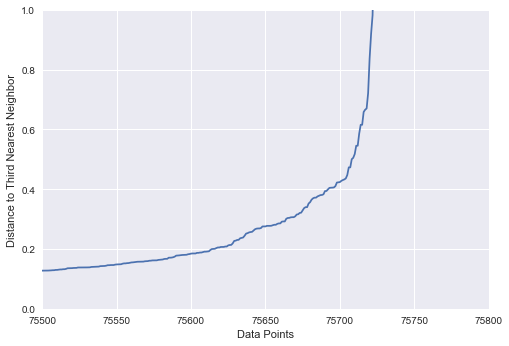

In [19]:
df = pd.read_csv('sold_data_scores.csv')
df = df[df.logerror > -0.39]
df = df[df.logerror < 0.39]
df = df.reset_index(drop=True)
tmp = df.loc[:,'geo_score']
tmp.fillna(tmp.mean(), inplace=True)

cluster_pt_arr = df.loc[:, ['score', 'geo_score']].as_matrix()
print(cluster_pt_arr.shape)

nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(cluster_pt_arr)
distances, indices = nbrs.kneighbors(cluster_pt_arr)
dist = distances[:,2]
dist = np.sort(dist)
print(dist.shape)
x = [i for i in range(len(dist))]
plt.ylim(0,1)
plt.ylabel('Distance to Third Nearest Neighbor')
plt.xlabel('Data Points')
plt.xlim(75500, 75800)
plt.plot(x, dist)
plt.show()

**Looking at the graph, you can see that 'knee' occurs ~0.6, so we use eps=0.6 for DBSCAN to find number of clusters**

#### Finding Number of Clusters Using DBSCAN

In [ ]:
eps = 0.6
db = DBSCAN(eps=eps).fit(cluster_pt_arr)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters)

#### Create Clusters Using K-Means
- Esitmated Number of Clusters from DBSCAN is '2'. Lets use that while doing K-Means.

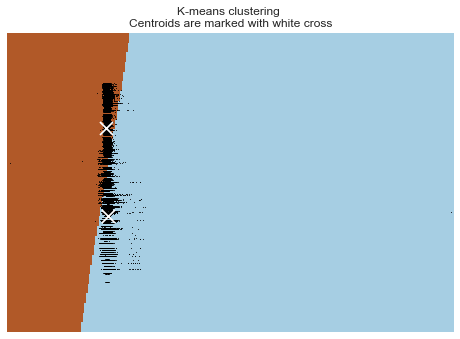

In [23]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cluster_pt_arr)
# Plot the decision boundary. For that, we will assign a color to each
h = 0.2
x_min, x_max = cluster_pt_arr[:, 0].min() - 1, cluster_pt_arr[:, 0].max() + 1
y_min, y_max = cluster_pt_arr[:, 1].min() - 1, cluster_pt_arr[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(cluster_pt_arr[:, 0], cluster_pt_arr[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering \n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Part 4
    
   Since we have used the geograhical score (generated using **Altos Research** dataset) in finding the most/least desirable house in previous parts, we explained the external dataset (**Altos Research** dataset) in **Part 2** in *"Geographical Score"* section. We have also showed the impact of external dataset in **Part 5** that our best model is using Geographical score clustering which gives us a very nice improvement.

## Part 5 
    We tried a bunch of things which are as follows
- Clustering based on Desirability and Regression on Features
- Predicting logerror just using the desirablility
- Regression on Desirability
- Regression Using some Selected Features
- XGBoost on Features
- Taking care of Outliers while training
- Different combination of features
- Polynomial feature engineering
- Polynomial Regression and Boosting
- Clustering based on Desirability and regression using XGBoost on selected features of properties already given to us (**This worked best**)


In [24]:
## Reading Data
properties_raw = pd.read_csv('properties_2017.csv')
parcelid = properties_raw['parcelid'].astype(np.int32)

parcelid_df = pd.DataFrame(parcelid)

## features we are interested in 
to_keep = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock']

# extracting required features and normalizing data
properties = properties_raw.loc[:, to_keep]

for c in properties.columns:
    properties[c]=properties[c].fillna(properties[c].mean())
    if properties[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties[c].values))
        properties[c] = lbl.transform(list(properties[c].values))
        
properties_norm = (properties - properties.mean())/properties.std()
properties_id = pd.concat([parcelid_df, properties_norm], axis=1)


# merging scored data and desired features
df = pd.read_csv('sold_data_scores.csv')
df = df[df.logerror > -0.39]
df = df[df.logerror < 0.39]
df = df.reset_index(drop=True)
df = df.merge(properties_id, how='left', on='parcelid')


# extracting scores from the merged data for clustering
cluster_pt_arr = df.loc[:, ['score', 'geo_score']].as_matrix()
logerror_arr = df.loc[:, 'logerror'].values
print(cluster_pt_arr.shape)
print(logerror_arr.shape)

# merging features of all the data with scores of all the data into one dataframe
tot_df = pd.read_csv('all_scores.csv')
tmp = tot_df.loc[:,'geo_score']
tmp.fillna(tmp.mean(), inplace=True)
tot_df = tot_df.merge(properties_id, how='left', on='parcelid')
data = tot_df.loc[:, ['score', 'geo_score']]
data = (data - data.mean())/(data.std(ddof=0))
to_pred = data.as_matrix()

#do clustering based on score and geoscore
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters).fit(cluster_pt_arr)
models = []
ids = []
log_err = []

for c in range(n_clusters):
	# find the shortlisted features for points that belong to the same cluster
	curr_cluster_points = [df.loc[i, to_keep].as_matrix().tolist() for i, l in enumerate(kmeans.labels_) if l == c]
	curr_log_err = [df.loc[i, 'logerror'] for i, l in enumerate(kmeans.labels_) if l == c]

	print('total points in this cluster : ', len(curr_cluster_points))
	print('cluster : ', c)

	# train a xgboost regressor for each cluster using the shortlisted features of classified points 
	logerror_mean = mean(curr_log_err)
	xgb_params = {
	    'eta': 0.037,
	    'max_depth': 5,
	    'subsample': 0.80,
	    'objective': 'reg:linear',
	    'eval_metric': 'mae',
	    'lambda': 0.8,   
	    'alpha': 0.4, 
	    'base_score': logerror_mean,
	    'silent': 1
	}
	num_boost_rounds = 250
	dtrain = xgb.DMatrix(curr_cluster_points, curr_log_err)
	model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
	models.append(model)


# predict clusters of all the data using scores and geoscores
label_list = kmeans.predict(to_pred)


# Using the clusters find the predicted logerror for each point using shortlisted features using the regressor that belong
# to the cluster to which the point is classified
for c in range(n_clusters):
	points_to_pred_index = [i for i, l in enumerate(label_list) if l == c]
	points_to_pred = tot_df.loc[points_to_pred_index, to_keep].as_matrix().tolist()
	new_ids = tot_df.loc[points_to_pred_index, 'parcelid'].as_matrix().tolist()
	points_to_pred = xgb.DMatrix(points_to_pred)
	new_logerr = models[c].predict(points_to_pred).tolist()
	ids += new_ids
	log_err += new_logerr


# Create an output file  for submission
print(len(log_err))
y_pred = pd.DataFrame(log_err)
ids = pd.DataFrame(ids)
ids = ids.astype(str)
print(y_pred.shape)
print(ids.shape)
sub = pd.concat([ids, y_pred, y_pred, y_pred, y_pred, y_pred, y_pred], axis=1)
sub.columns = ['ParcelId', '201610', '201611', '201612', '201710', '201711', '201712']
sub.to_csv('final_xgb_2_outlierRM_cluster_org_col.csv', index=False, mode='w')


/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(75728, 2)
(75728,)
total points in this cluster :  42957
cluster :  0
total points in this cluster :  32771
cluster :  1
2985217
(2985217, 1)
(2985217, 1)


## Part 6
   In this part, we subsampled our data. Because running permutation test for the whole data is very time consuming. We randomly selected 10000 point from our point distribution for the training set. We have randomly selected another 10000 non-overlapping points as our test set. In the first iteration, we do not change the order of the ylabels and record our MAE/MSE. In all the next iteration we reandomly reorder the ylabels. Since clustering is a part of our hypothesis, we scramble the non-geographic/geographic scores as well. The code and respective output is shown below.


In [28]:
# merging scored data and desired features
df = pd.read_csv('sold_data_scores.csv')
df = df[df.logerror > -0.39]
df = df[df.logerror < 0.39]
df = df.reset_index(drop=True)
df = df.merge(properties_id, how='left', on='parcelid')

df = shuffle(df)
headSize = 10000
tot_df = df.tail(int(headSize*1.0)) #(len(df)-headSize)
df = df.head(headSize)

df.index = range(len(df.index))
tot_df.index = range(len(tot_df.index))

# data to predict
data = tot_df.loc[:, ['score', 'geo_score']]
data = (data - data.mean())/(data.std(ddof=0))
to_pred = data.as_matrix()

tot_test = tot_df.loc[:, ['parcelid', 'logerror']]


permutations_mse = []
permutations_mae = []
for permutations in range(201):
#     print("###### Permutation: %d ######" % permutations)
    # extracting scores from the merged data for clustering
    cluster_pt_arr = df.loc[:, ['score', 'geo_score']].as_matrix()
    logerror_arr = df.loc[:, 'logerror'].values

    #do clustering based on score and geoscore
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters).fit(cluster_pt_arr)
    models = []
    ids = []
    log_err = []
    
    for c in range(n_clusters):
        # find the shortlisted features for points that belong to the same cluster
        curr_cluster_points = [df.loc[i, to_keep].as_matrix().tolist() for i, l in enumerate(kmeans.labels_) if l == c]
        curr_log_err = [df.loc[i, 'logerror'] for i, l in enumerate(kmeans.labels_) if l == c]
#         print('Cluster: %d Number of points : %d' % (c, len(curr_cluster_points)))

        # train a xgboost regressor for each cluster using the shortlisted features of classified points 
        logerror_mean = mean(curr_log_err)
        xgb_params = {
            'eta': 0.037,
            'max_depth': 5,
            'subsample': 0.80,
            'objective': 'reg:linear',
            'eval_metric': 'mae',
            'lambda': 0.8,   
            'alpha': 0.4, 
            'base_score': logerror_mean,
            'silent': 1
        }
        num_boost_rounds = 250
        dtrain = xgb.DMatrix(curr_cluster_points, curr_log_err)
        model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
        models.append(model)

    # predict clusters of all the data using scores and geoscores
    label_list = kmeans.predict(to_pred)

    # Using the clusters find the predicted logerror for each point using shortlisted features using the regressor that belong
    # to the cluster to which the point is classified
    for c in range(n_clusters):
        points_to_pred_index = [i for i, l in enumerate(label_list) if l == c]
        points_to_pred = tot_df.loc[points_to_pred_index, to_keep].as_matrix().tolist()
        new_ids = tot_df.loc[points_to_pred_index, 'parcelid'].as_matrix().tolist()
        points_to_pred = xgb.DMatrix(points_to_pred)
        new_logerr = models[c].predict(points_to_pred).tolist()
        ids += new_ids
        log_err += new_logerr

    tot_pred = pd.DataFrame({'parcelid': ids, 'ypred': log_err})
    tot_final = tot_test.merge(tot_pred, how='left', on='parcelid')
    mse_cur = mean_squared_error(tot_final['logerror'].tolist(), tot_final['ypred'].tolist())
    mae_cur = mean_absolute_error(tot_final['logerror'].tolist(), tot_final['ypred'].tolist())
#     print("Mean squared error: %.5f" % mse_cur)
#     print("Mean absolute error: %.5f" % mae_cur)
    permutations_mse.append(mse_cur)
    permutations_mae.append(mae_cur)

    tmp = shuffle(df['geo_score'])
    tmp.reset_index(inplace=True, drop=True)
    df['geo_score'] = tmp
    
    tmp = shuffle(df['score'])
    tmp.reset_index(inplace=True, drop=True)
    df['score'] = tmp
    
    tmp = shuffle(df['logerror'])
    tmp.reset_index(inplace=True, drop=True)
    df['logerror'] = tmp
    
perm_errors = pd.DataFrame({'mse': permutations_mse, 'mae': permutations_mae})
perm_errors.to_csv("permutation_score.csv", index = False)

/Users/zafar-PC/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cluster: 0 Number of points : 5761
Cluster: 1 Number of points : 4239


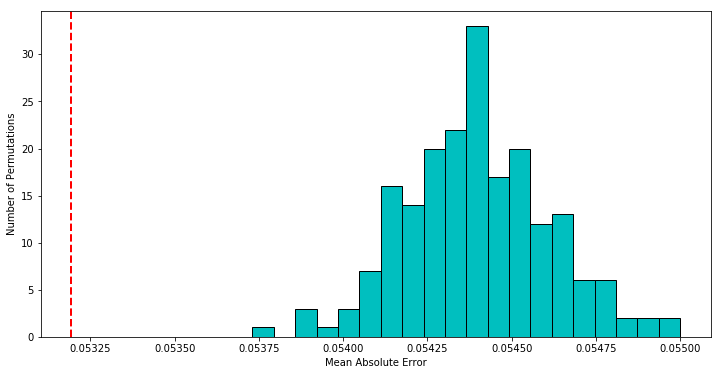

In [30]:
perm_errors = pd.read_csv('permutation_score.csv')
permutations_mae = perm_errors['mae'].tolist()
permutations_mse = perm_errors['mse'].tolist()

mae_list = permutations_mae[1:]
plt.rcParams["figure.figsize"] = [12, 6]
plt.hist(mae_list, bins=20, color='c', edgecolor = 'black')
plt.axvline(permutations_mae[0], color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Mean Absolute Error')
plt.ylabel('Number of Permutations')
plt.show()

#### Explanation
We ran our experiment for 200 permutaions of training data. From the above figure it looks like our __P-value__ is **Zero**. However, we are generating permutaions for 10000 points and number of possible permutaions of 10000 points is **10000!**, which is impossible or not feasible to generate. If we could have generated all these permutations we would have seen some permutation's MAE could be less than ours. From the above figure we can infer that even if the P-value does not become Zero in long run but it will remain close to zero.

## Part 7
   We have submitted our prediction in Kaggle. Since we were unable to create team in Kaggle and talked to both TA and Professor about this, we used **Uhafeez** account to submit our prediction. Result are given below:

**MAE: 0.0648731**

**Rank: 2425**